# Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from PIL import Image
from tensorflow.keras.optimizers import Adam


%matplotlib inline

2024-05-20 00:37:31.857996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 00:37:31.858096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 00:37:31.987221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Assigning Path for Dataset

In [3]:

data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

# Label Overview

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# Visualizing The Dataset

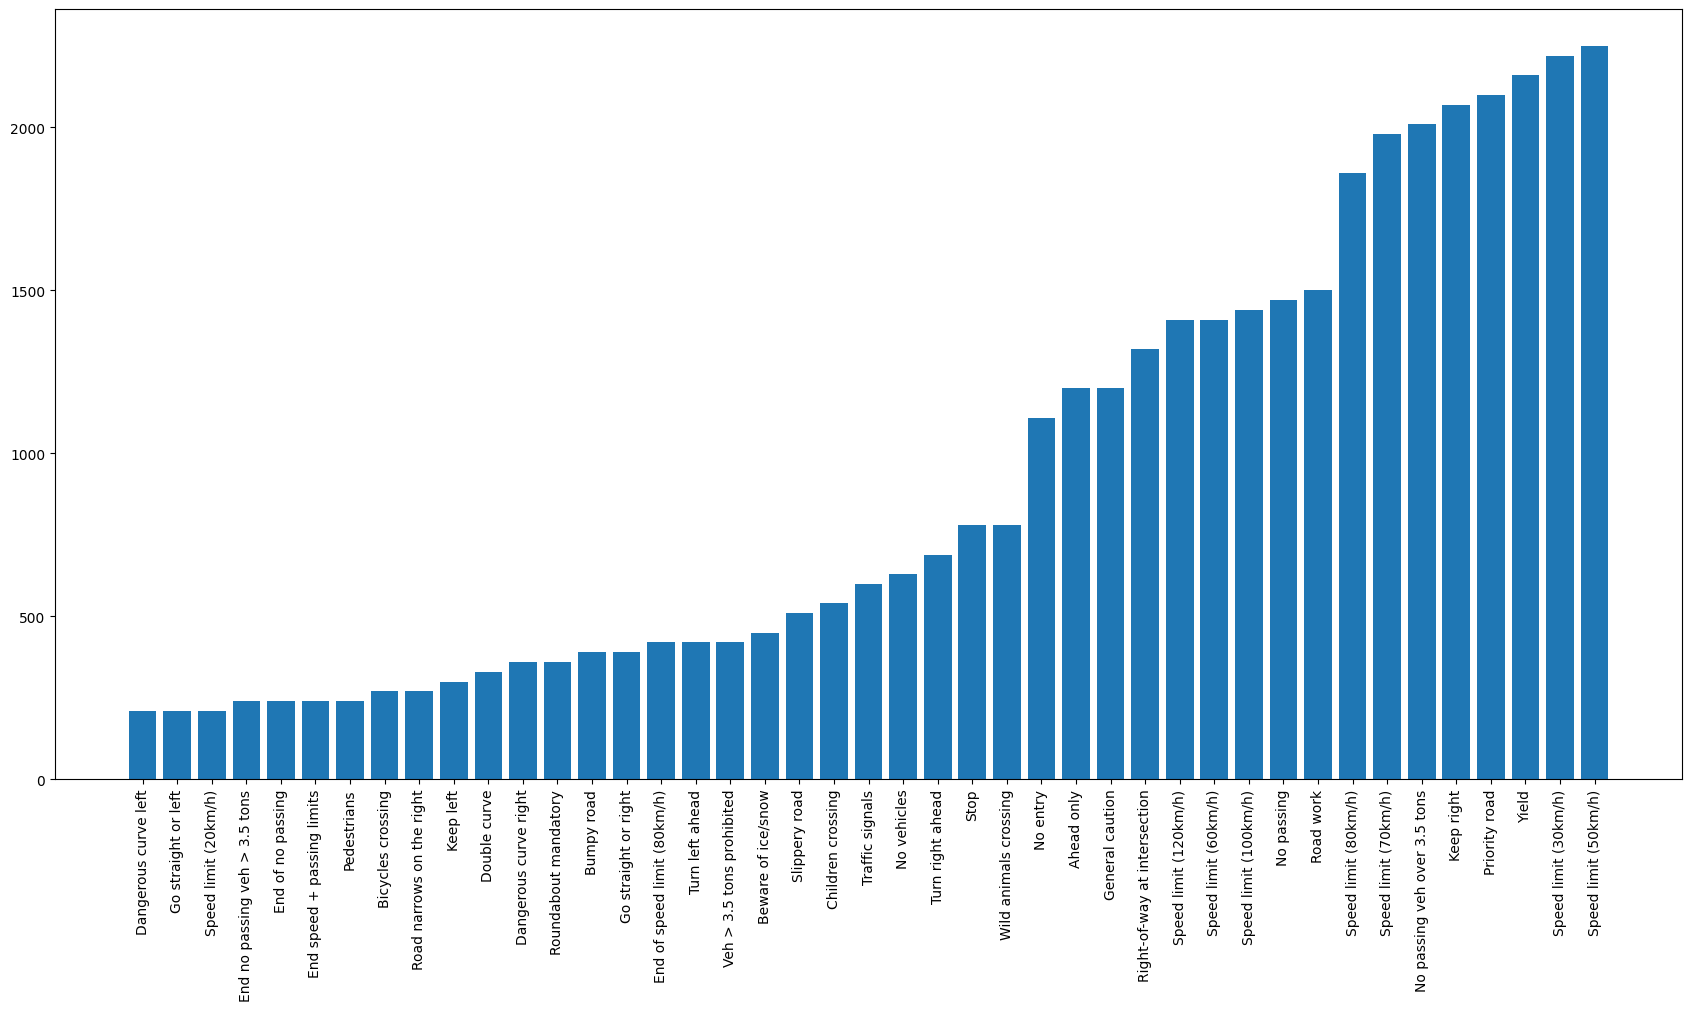

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

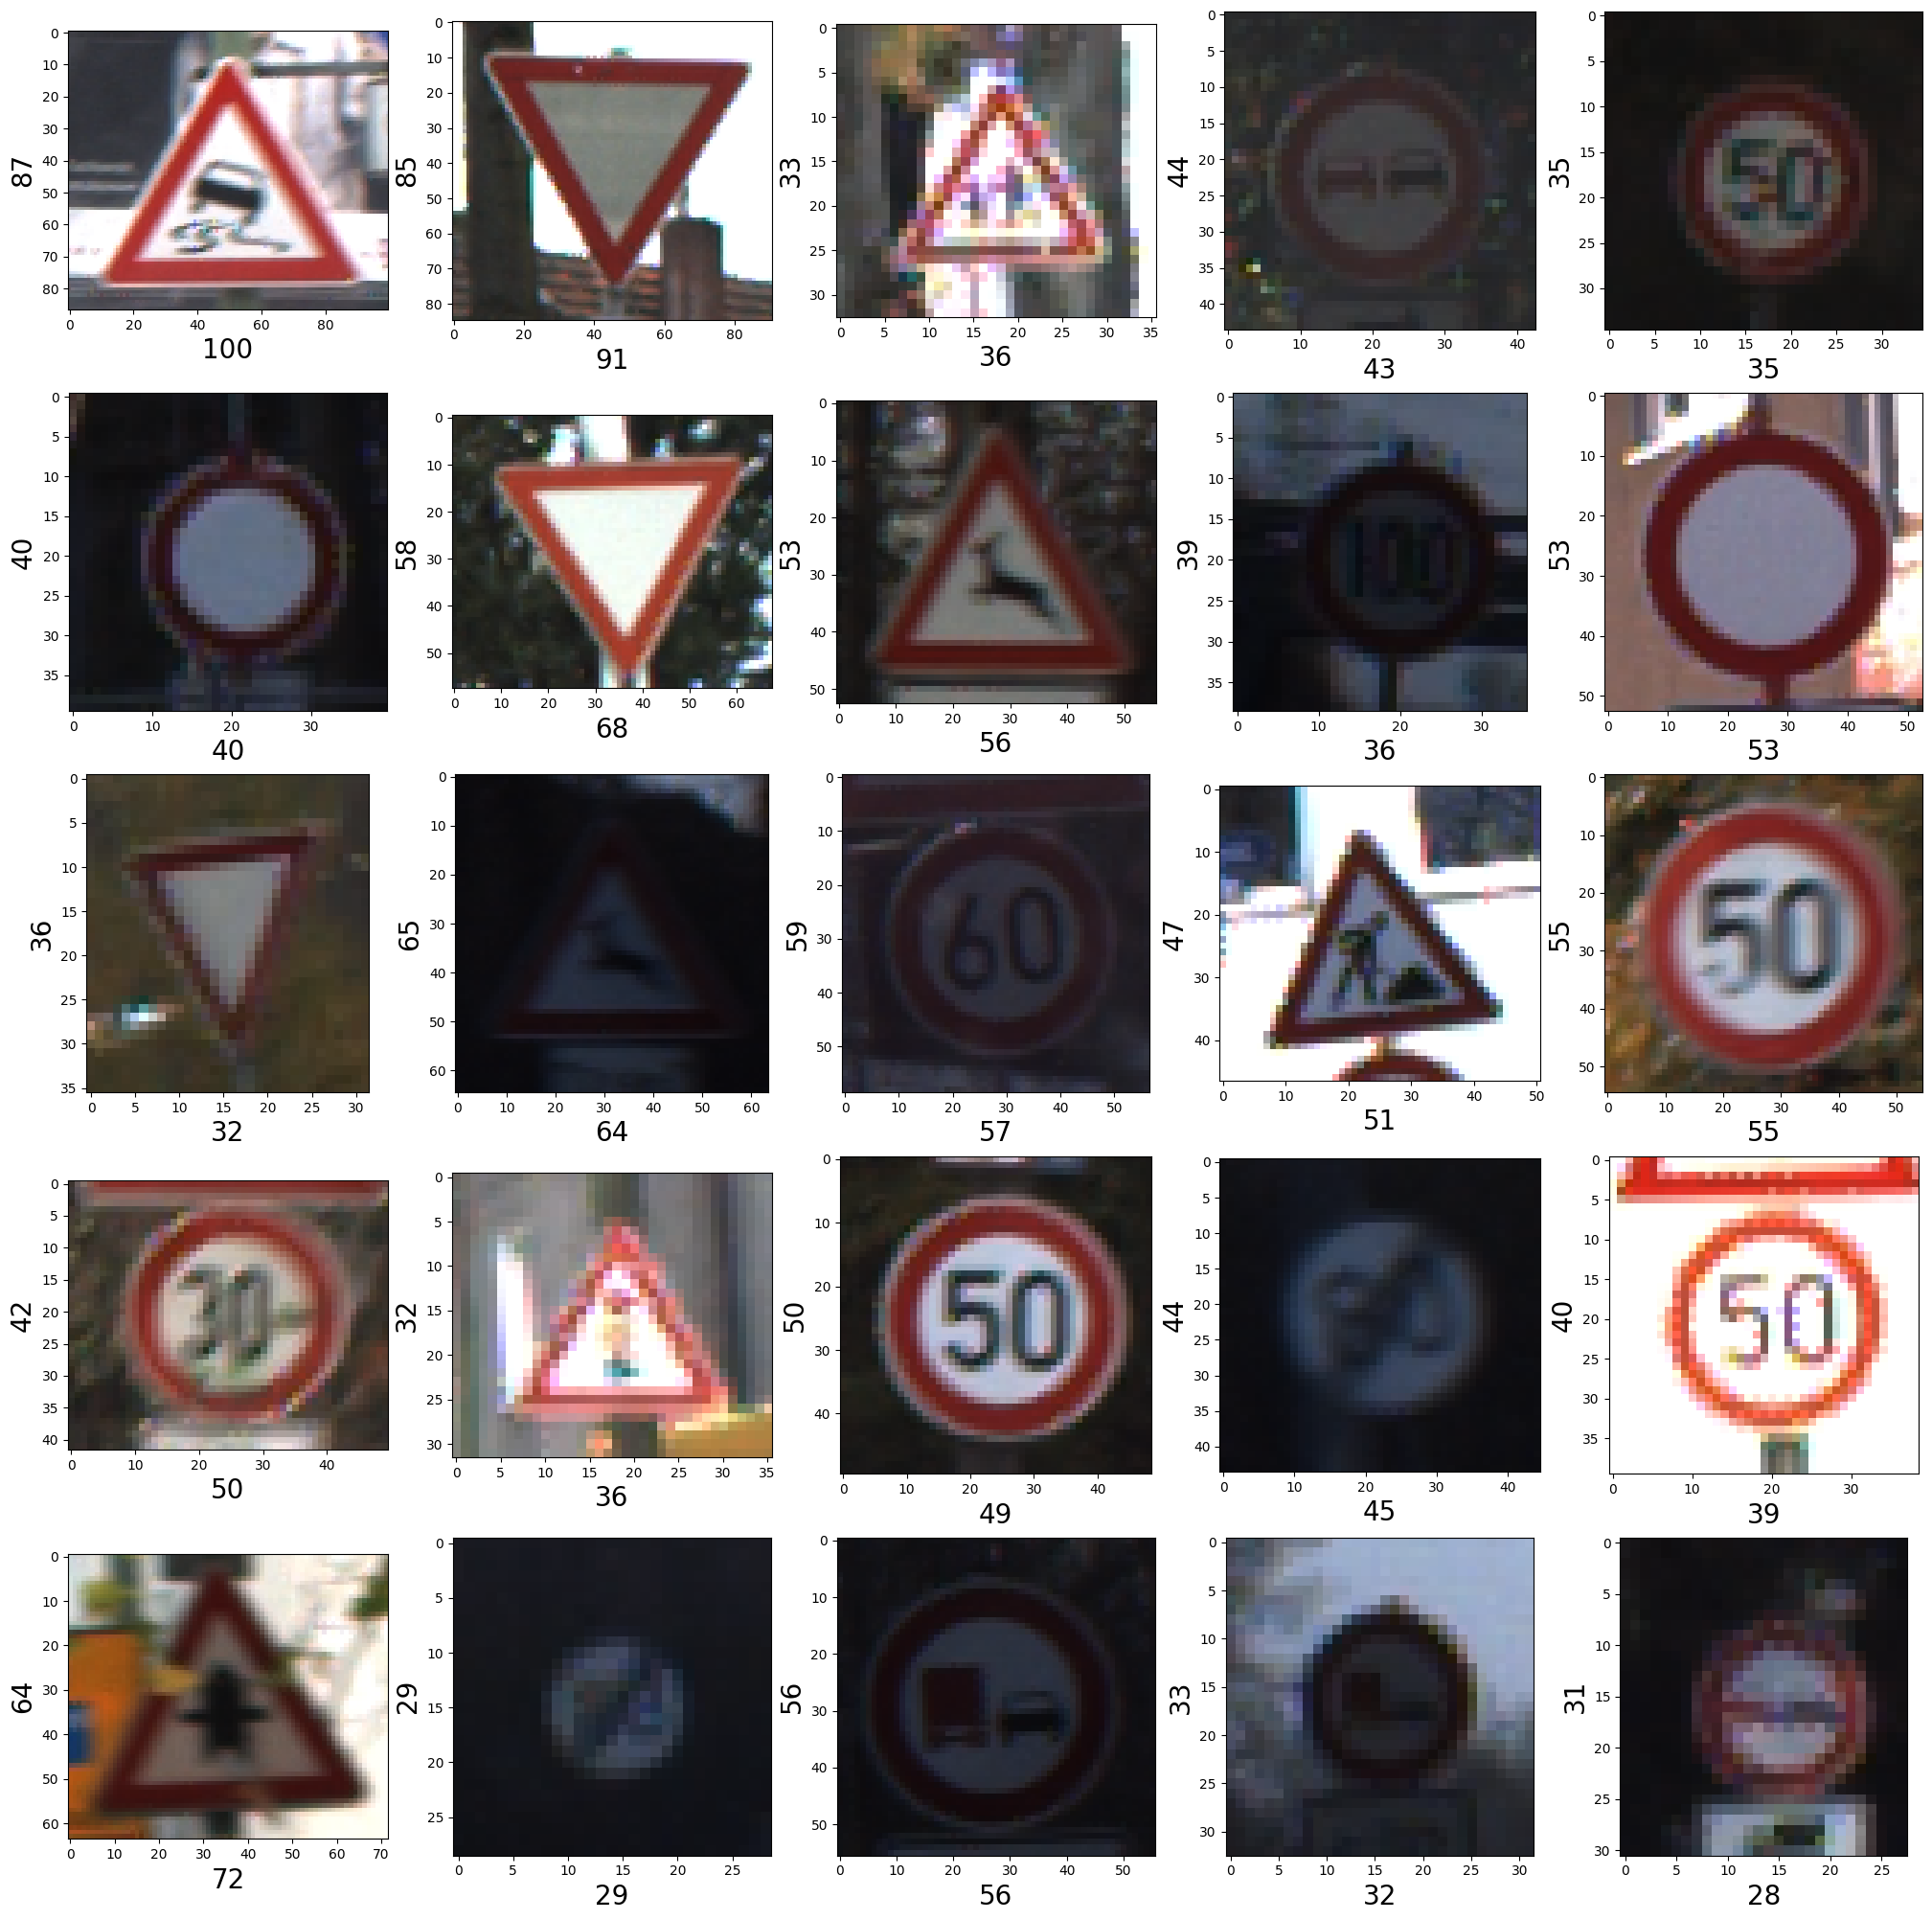

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=0)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

# Loading data from Train folder

In [7]:
def load_data(data_dir):
   
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(30, 30))
            image = img_to_array(img)
            images.append(image)
            labels.append(category)
    
    return images, labels
        

In [8]:
images, labels = load_data(train_path)

# One hot encoding the labels
labels = to_categorical(labels)

# Splitting the dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(
                                                    np.array(images),
                                                    labels,
                                                    test_size=0.3 , 
                                                    random_state=42, 
                                                    shuffle=True
                                                    )

In [9]:
x_train = x_train/255 
x_test = x_test/255

In [10]:
print("X_train.shape", x_train.shape)
print("X_valid.shape", x_test.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_test.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446, 43)
y_valid.shape (11763, 43)


# Creating the Model

In [11]:

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,587 (4.46 MB)

 Trainable params: 1,168,587 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling the model

In [12]:

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#  Fitting the model

In [13]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


EPOCHS = 30
history = model.fit(aug.flow(x_train, 
                    y_train, batch_size = 32),
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS   
                   )


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  8/858 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.0365 - loss: 3.7348    

I0000 00:00:1716165725.616246     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716165725.634375     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/858 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.0965 - loss: 3.3845

W0000 00:00:1716165748.036537     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


854/858 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2260 - loss: 2.8083

W0000 00:00:1716165759.546600     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.2271 - loss: 2.8036 - val_accuracy: 0.8859 - val_loss: 0.4075
Epoch 2/30
  1/858 ━━━━━━━━━━━━━━━━━━━━ 2:14 156ms/step - accuracy: 0.7812 - loss: 0.8839

W0000 00:00:1716165761.217480     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.7613 - loss: 0.7310 - val_accuracy: 0.9715 - val_loss: 0.1111
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8776 - loss: 0.3749 - val_accuracy: 0.9850 - val_loss: 0.0524
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9174 - loss: 0.2637 - val_accuracy: 0.9833 - val_loss: 0.0581
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9401 - loss: 0.1898 - val_accuracy: 0.9909 - val_loss: 0.0322
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9431 - loss: 0.1774 - val_accuracy: 0.9952 - val_loss: 0.0167
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9558 - loss: 0.1359 - val_accuracy: 0.9947 - val_loss: 0.0197
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9568 - loss: 0.1411 - val_accuracy: 0.9901 - val_loss: 0.0351
Epoch 9/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9641 - loss: 0.1191 - val_accurac

In [19]:
model.save('/kaggle/working/my_model.h5')

In [14]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9976 - loss: 0.0094
test set accuracy:  99.71945881843567


# Plotting the Accuracy and Loss values

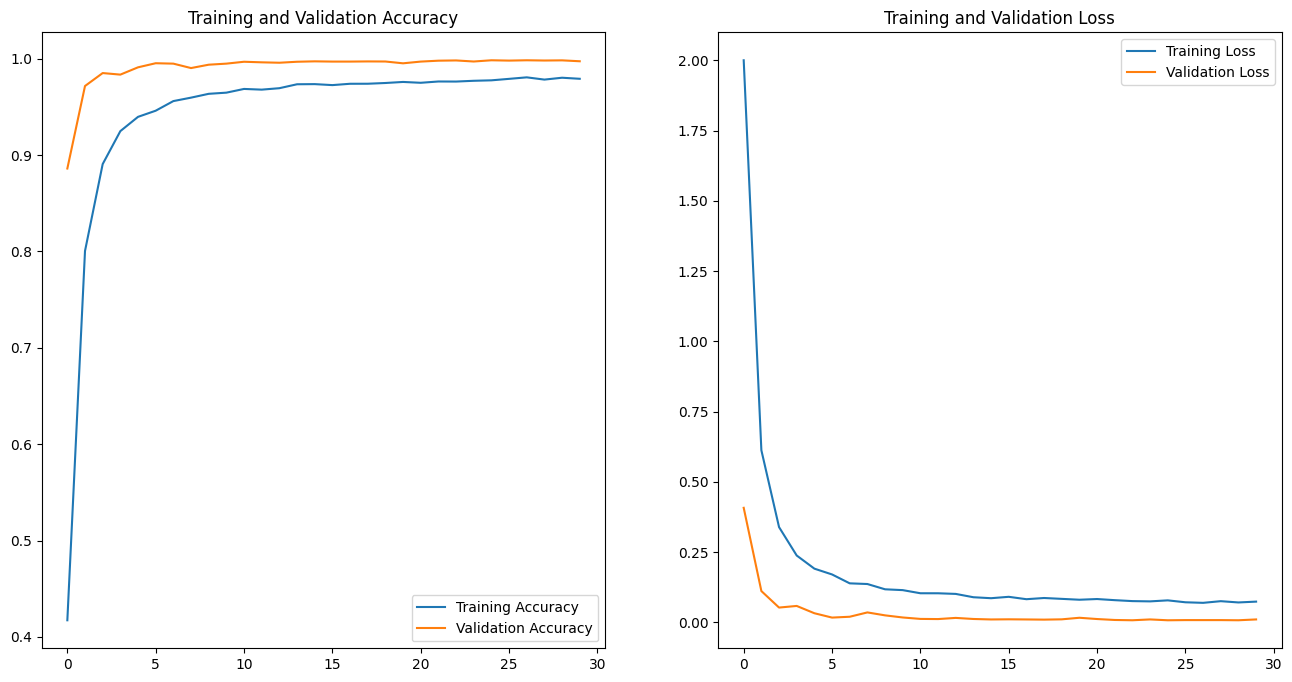

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# find the predictions

In [16]:
from sklearn.metrics import accuracy_score
import pandas as pd

Y_test = pd.read_csv(test_path + 'Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(30, 30))
    output.append(np.array(image))

X_test=np.array(output)
pred = model.predict(X_test)
pred=np.argmax(pred, axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

105/395 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1716166347.738644     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1716166348.706626     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Data accuracy:  96.5083135391924


# visualize Predictions

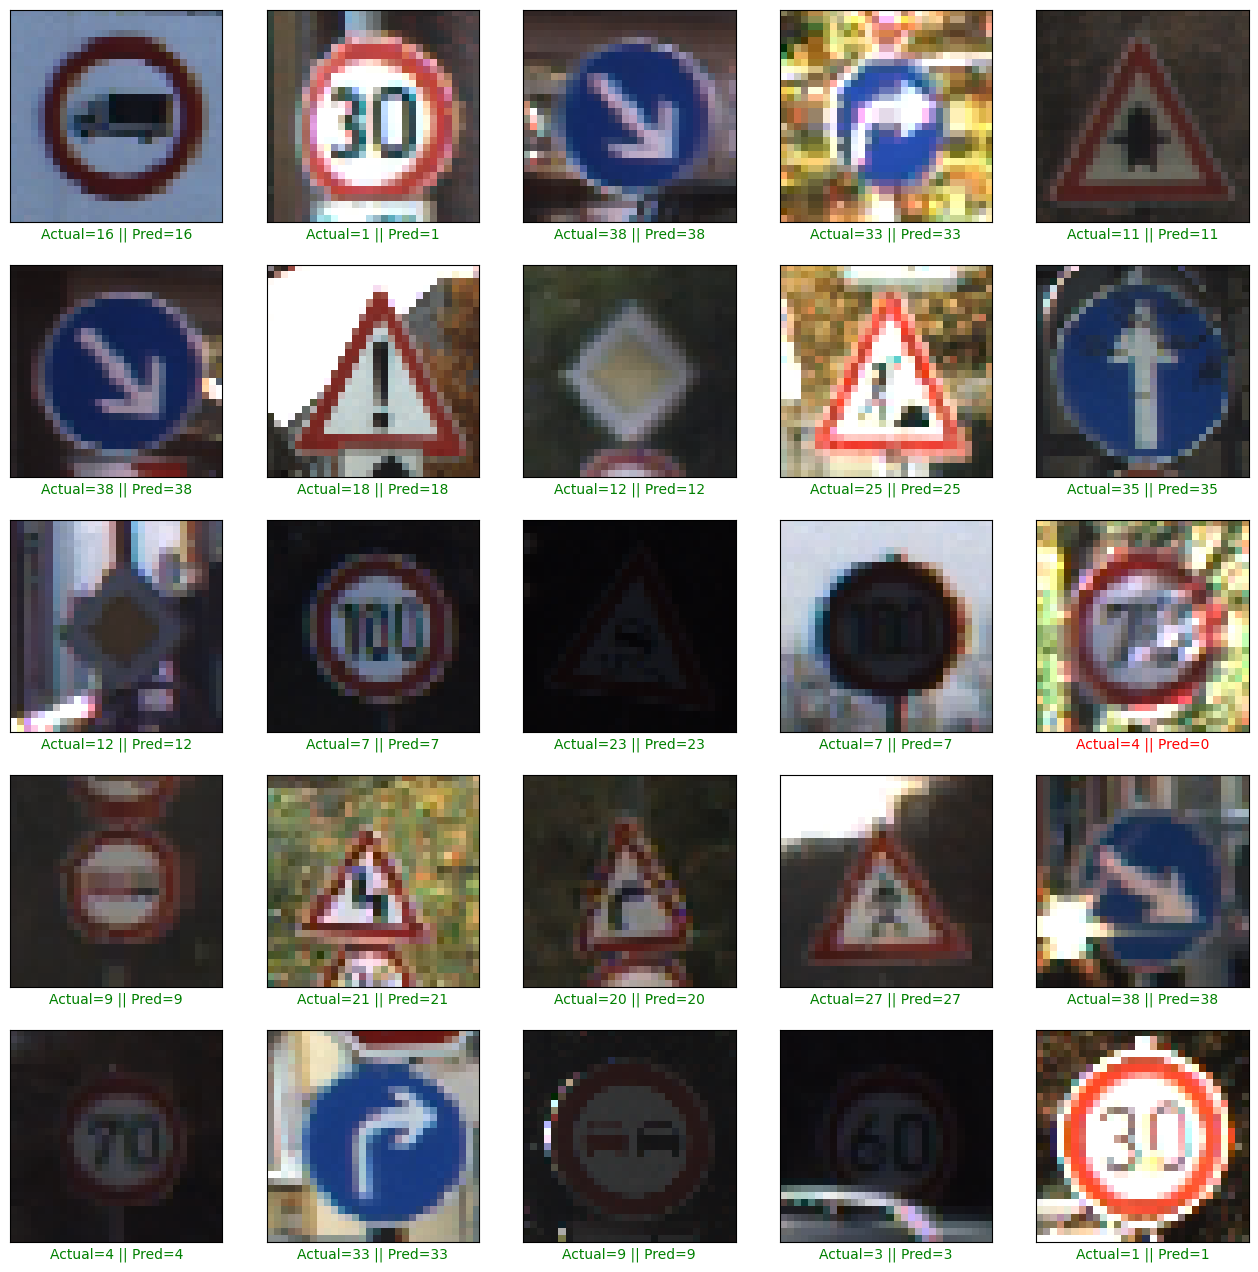

In [17]:
plt.figure(figsize = (16, 16))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

<Axes: >

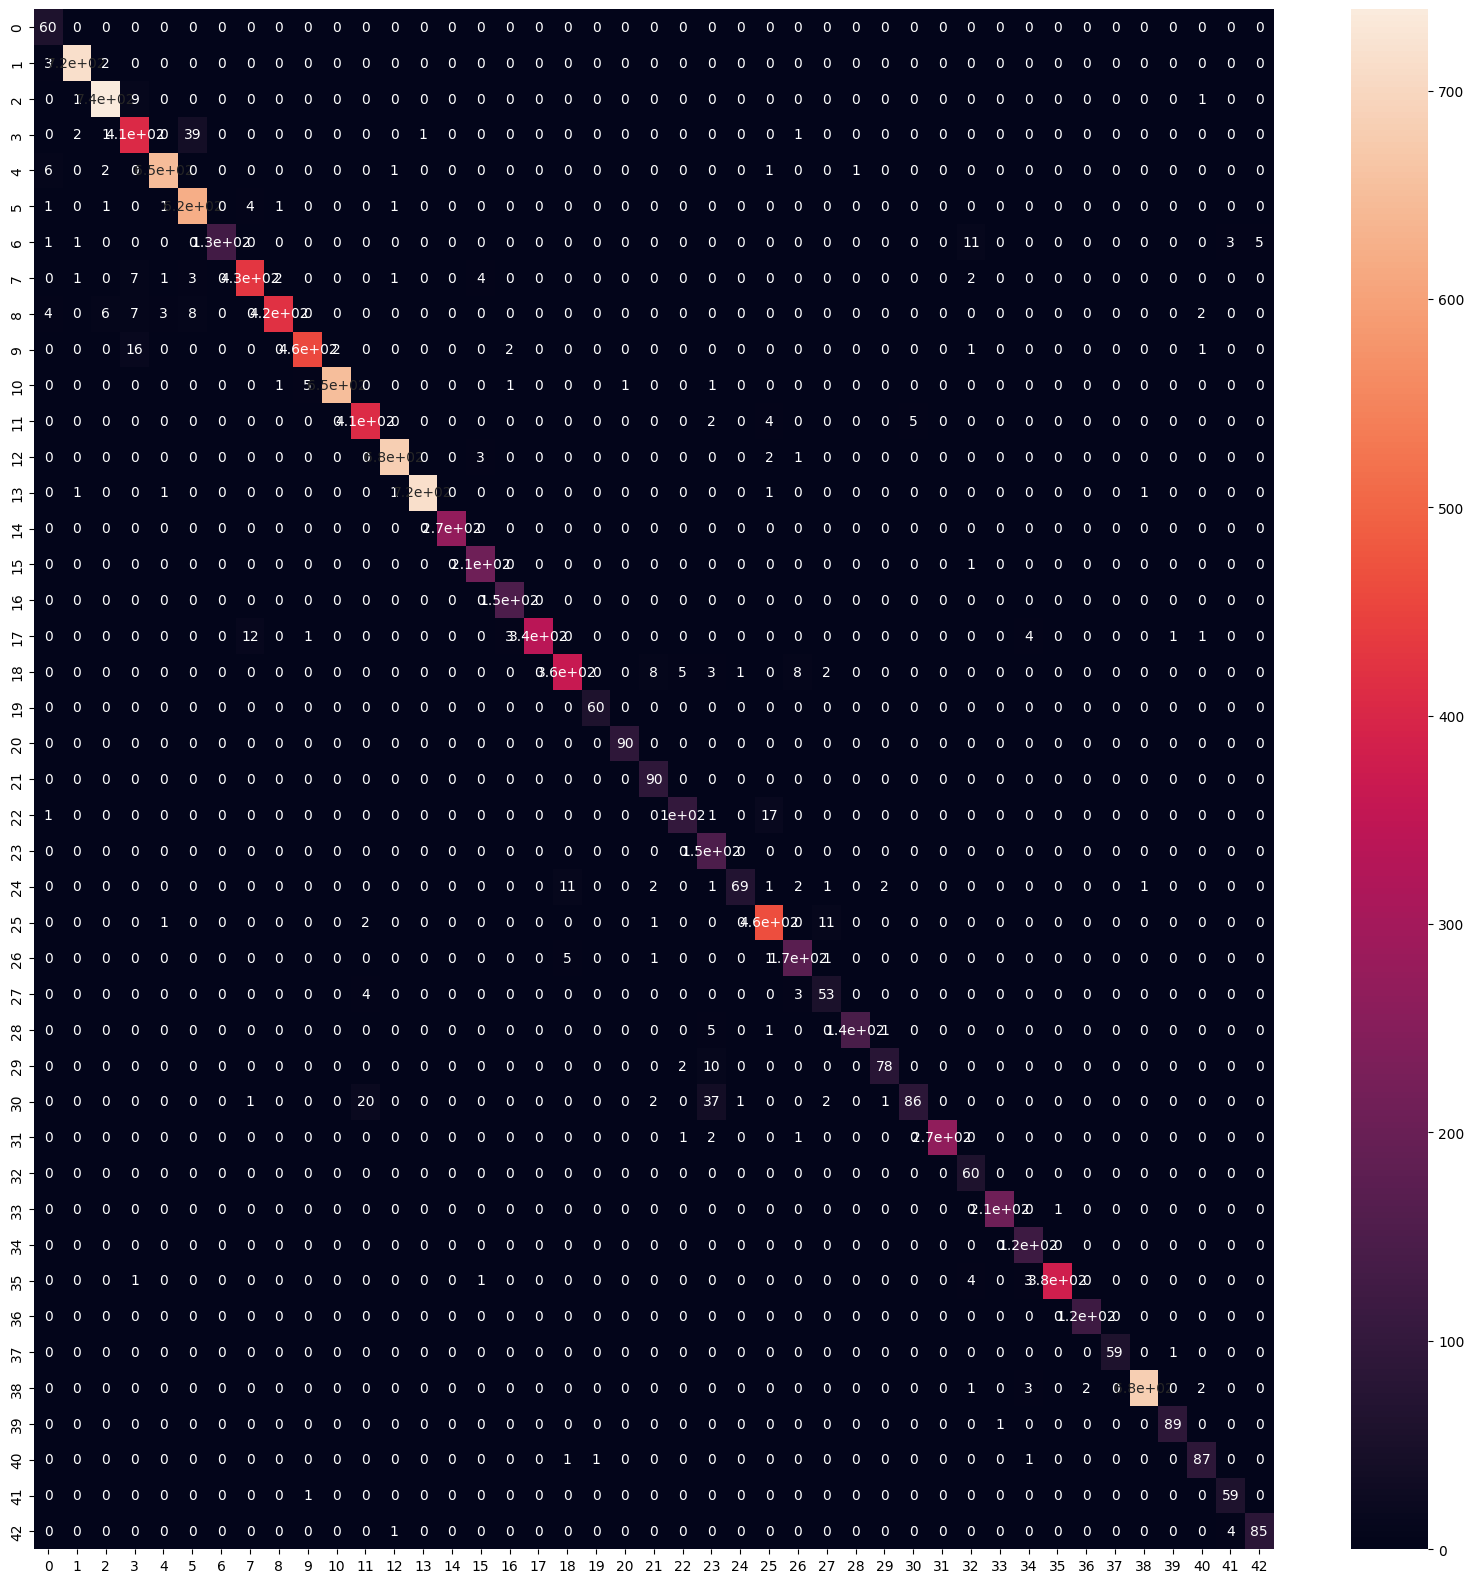

In [18]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_labels,pred )
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)